## Задача проекта: провести разведывательный анализ данных и составить отчёт по его результатам.

## Цель проекта: выявить какие условия жизни учащихся в возрасте от 15 до 22 лет оказывают влияние на их успеваемость по математике.

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
from sklearn.impute import SimpleImputer

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

stud = pd.read_csv('stud_math.xlt')

In [2]:
stud.head(10)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


In [3]:
stud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

In [106]:
# Functions for preparing data
def replaceNullToNaN(column):
    return column.astype(str).apply(lambda x: None if pd.isnull(x) else None if x == 'nan'
                                    else x if '(' not in x else x[:x.find('(')].strip())


def normalizeAddress():
    return stud.address.apply(lambda x: 'urban' if x == 'U' else ('suburban' if x == 'R' else x))


def normalizeFamSize():
    return stud.famsize.apply(lambda x: 'more 3' if x == 'GT3' else ('less or equal 3' if x == 'LE3' else x))


def normalizeParentStatus():
    return stud.Pstatus.apply(lambda x: 'together' if x == 'T' else ('apart' if x == 'A' else x))


def normalizeTraveltime():
    return stud.traveltime.astype(str).apply(setValuesForTraveltime)


def setValuesForTraveltime(x):
    if x == '1.0':
        return '<15 min'
    elif x == '2.0':
        return '15-30 min'
    elif x == '3.0':
        return '30-60 min'
    elif x == '4.0':
        return '>60 min'
    else:
        return x


def normalizeStudytime():
    return stud.studytime.astype(str).apply(setValuesForStudytime)


def setValuesForStudytime(x):
    if x == '1.0':
        return '<2 h'
    elif x == '2.0':
        return '2-5 h'
    elif x == '3.0':
        return '5-10 h'
    elif x == '4.0':
        return '>10 h'
    else:
        return x


def normalizeEducation(column):
    return column.astype(str).apply(lambda x: 'no education' if x == '0.0' else ('1-4 gr.' if x == '1.0' else ('5-9 gr.' if x == '2.0' else ('secondary' if x == '3.0' else ('higher' if x == '4.0' else x)))))

def countNaNValues():
    for col in ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'studytime, granular', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health', 'absences', 'score']:
        print(f'Столбец {col} имеет {stud[col].isnull().sum()} пустых значений.')

# Первичный анализ данных

Text(0.5, 1, 'Missing values heatmap')

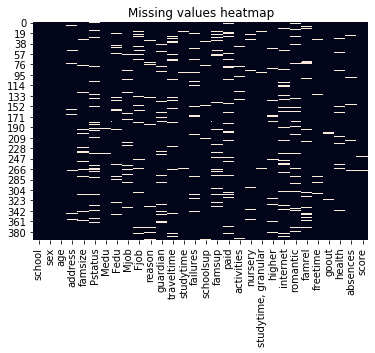

In [5]:
stud.isnull().sum()
sns.heatmap(stud.isnull(), cbar=False).set_title("Missing values heatmap")

In [88]:
print(f'{stud.isnull().any().sum()} колонок содержат пустые значения.')

27 колонок содержат пустые значения.


### Предоставленные данные имеют очень много пропущенных значений. Не имеют пропущенных значений только столбцы school, age, sex.


In [107]:
countNaNValues()

Столбец school имеет 0 пустых значений.
Столбец sex имеет 0 пустых значений.
Столбец age имеет 0 пустых значений.
Столбец address имеет 17 пустых значений.
Столбец famsize имеет 27 пустых значений.
Столбец Pstatus имеет 45 пустых значений.
Столбец Medu имеет 3 пустых значений.
Столбец Fedu имеет 24 пустых значений.
Столбец Mjob имеет 19 пустых значений.
Столбец Fjob имеет 36 пустых значений.
Столбец reason имеет 17 пустых значений.
Столбец guardian имеет 31 пустых значений.
Столбец traveltime имеет 28 пустых значений.
Столбец studytime имеет 7 пустых значений.
Столбец failures имеет 22 пустых значений.
Столбец schoolsup имеет 9 пустых значений.
Столбец famsup имеет 39 пустых значений.
Столбец paid имеет 40 пустых значений.
Столбец activities имеет 14 пустых значений.
Столбец nursery имеет 16 пустых значений.
Столбец studytime, granular имеет 7 пустых значений.
Столбец higher имеет 20 пустых значений.
Столбец internet имеет 34 пустых значений.
Столбец romantic имеет 31 пустых значений.


## Попробуем восстановить данные

In [7]:
imp = SimpleImputer(strategy="most_frequent")
stud = pd.DataFrame(data=imp.fit_transform(stud), columns=['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
                                                           'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
                                                           'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
                                                           'studytime, granular', 'higher', 'internet', 'romantic', 'famrel',
                                                           'freetime', 'goout', 'health', 'absences', 'score'])

# приведем absences, age, score и др. к числовым типам
stud["absences"] = pd.to_numeric(stud["absences"], downcast='float')
stud["score"] = pd.to_numeric(stud["score"], downcast='float')
stud["age"] = pd.to_numeric(stud["age"], downcast='float')
stud["famrel"] = pd.to_numeric(stud["famrel"], downcast='float')
stud["freetime"] = pd.to_numeric(stud["freetime"], downcast='float')
stud["goout"] = pd.to_numeric(stud["goout"], downcast='float')
stud["health"] = pd.to_numeric(stud["health"], downcast='float')


stud.head(10)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18.0,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,-6,yes,yes,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17.0,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,-6,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15.0,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,no,no,yes,-6,yes,yes,no,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15.0,U,GT3,T,4,2,health,other,home,mother,1,3,0,no,yes,yes,yes,yes,-9,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16.0,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,-6,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16.0,U,LE3,T,4,3,services,other,reputation,mother,1,2,0,no,yes,yes,yes,yes,-6,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16.0,U,LE3,T,2,2,other,other,home,mother,1,2,0,no,no,no,no,yes,-6,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17.0,U,GT3,A,4,4,other,teacher,home,mother,2,2,0,yes,yes,no,no,yes,-6,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15.0,U,LE3,A,3,2,services,other,home,mother,1,2,0,no,yes,yes,no,yes,-6,yes,yes,no,4.0,2.0,2.0,1.0,0.0,95.0
9,GP,M,15.0,U,GT3,T,3,4,other,other,home,mother,1,2,0,no,yes,yes,yes,yes,-6,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


## 1. Score

count    395.000000
mean      52.227848
std       22.745537
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

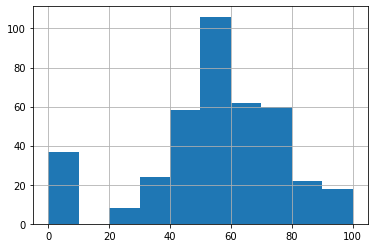

In [8]:
stud.score.hist()
stud.score.describe()

### Судя по гистограмме минимальное значение score равно 0. Но т.к. отсутствуют значения между 0 и 20 можно предположить, что это некорректные  данные. Рассмотрим их подробнее.

In [9]:
stud_0_score = stud[stud.score == 0]
stud_0_score['absences'].value_counts(dropna=False, normalize=False)

0.0    37
Name: absences, dtype: int64

### Данные, у которых значение  score равно 0, также имеют значение absences равное нулю или NaN. Поэтому можно их исключить из анализа, т.к. они являются некорректными.

In [10]:
stud = stud[stud['score'] > 0]

<h2>2. Absences<h2>

25-й перцентиль: 2.0, 75-й перцентиль: 8.0, IQR: 6.0,  Границы выбросов: [-7.0, 17.0].


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
40,GP,F,16.0,U,LE3,T,2,2,other,other,home,mother,2,2,1,no,yes,no,yes,no,-6,yes,yes,yes,3.0,3.0,3.0,3.0,25.0,55.0
74,GP,F,16.0,U,GT3,T,3,3,other,services,home,mother,1,2,0,yes,yes,yes,yes,yes,-6,yes,yes,no,4.0,3.0,3.0,5.0,54.0,55.0
89,GP,M,16.0,U,LE3,A,4,4,teacher,health,reputation,mother,1,2,0,no,yes,no,no,yes,-6,yes,no,no,4.0,1.0,3.0,5.0,18.0,35.0
103,GP,F,15.0,U,GT3,T,3,2,services,other,home,mother,2,2,0,yes,yes,yes,no,yes,-6,yes,yes,no,4.0,3.0,5.0,2.0,26.0,30.0
118,GP,M,17.0,R,GT3,T,1,3,other,other,course,father,3,2,1,no,yes,no,yes,yes,-6,yes,yes,no,4.0,2.0,4.0,5.0,20.0,40.0
123,GP,M,16.0,U,GT3,T,4,4,health,other,course,mother,1,1,0,no,yes,no,yes,yes,-3,yes,yes,no,3.0,4.0,4.0,5.0,18.0,65.0
183,GP,F,17.0,U,LE3,T,3,3,other,other,reputation,mother,1,2,0,no,yes,no,yes,yes,-6,yes,yes,yes,5.0,3.0,3.0,1.0,56.0,40.0
198,GP,F,17.0,U,GT3,T,4,4,services,teacher,home,mother,2,1,1,no,yes,no,no,yes,-3,yes,yes,no,4.0,2.0,4.0,2.0,24.0,90.0
203,GP,F,17.0,R,GT3,T,2,2,other,other,reputation,mother,1,1,0,no,yes,no,no,yes,-3,yes,yes,no,5.0,3.0,2.0,3.0,18.0,30.0
205,GP,F,17.0,U,GT3,T,3,4,at_home,services,home,mother,1,3,1,no,yes,yes,no,yes,-9,yes,yes,yes,4.0,4.0,3.0,5.0,28.0,45.0


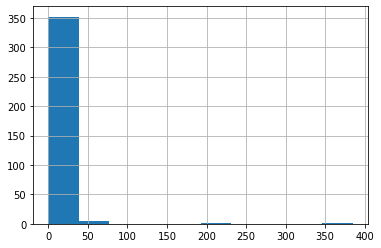

In [11]:
stud['absences'].value_counts(dropna=False, normalize=False)
median_abs = stud.absences.median()
IQR_abs = stud.absences.quantile(0.75) - stud.absences.quantile(0.25)
perc25_abs = stud.absences.quantile(0.25)
perc75_abs = stud.absences.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25_abs), '75-й перцентиль: {},'.format(perc75_abs), "IQR: {}, ".format(IQR_abs),
      "Границы выбросов: [{f}, {l}].".format(f=perc25_abs - 1.5*IQR_abs, l=perc75_abs + 1.5*IQR_abs))
stud_abs = stud[(stud.absences > perc75_abs + 1.5*IQR_abs)]
stud.absences.hist()
stud_abs

### Основываясь на гистограмме, можно сделать вывод, что данные больше 100 являются выбросами и их можно исключить из анализа.

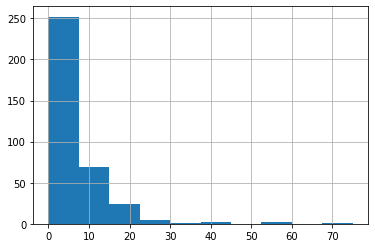

In [12]:
stud = stud[stud['absences'] < 100]
stud.absences.hist()

<h2>3. School<h2>

In [13]:
stud['school'].value_counts(dropna=False, normalize=False)

GP    315
MS     41
Name: school, dtype: int64

### В таблице представлены только 2 школы GP и MS. 

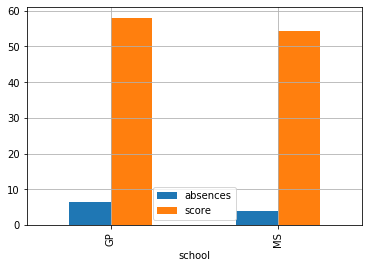

In [14]:
stud.pivot_table(values=['score', 'absences'], index='school',
                 aggfunc='mean').plot(kind='bar', grid=True)

### На представленном графике видно, что в школе GP ученики получают в среднем выше балл за экзамен, чем в школе MS. 


<h2>4. Sex<h2>

In [15]:
stud['sex'].value_counts(dropna=False, normalize=False)

F    185
M    171
Name: sex, dtype: int64

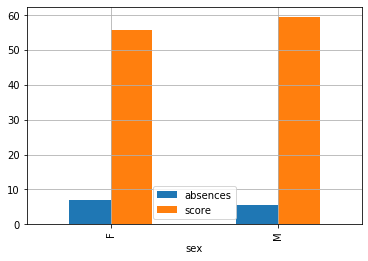

In [16]:
stud.pivot_table(values=['score', 'absences'], index='sex',
                 aggfunc='mean').plot(kind='bar', grid=True)

### На представленном графике видно, что в мальчики в среднем лучше сдают экзамен, чем девочки. Также мальчики меньше пропускают занятия.

25-й перцентиль: 1.75, 75-й перцентиль: 8.0, IQR: 6.25,  Границы выбросов: [-7.625, 17.375].


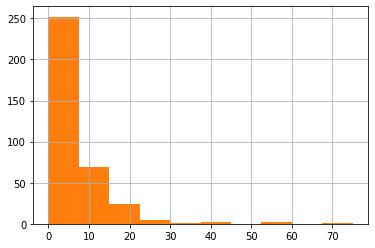

In [17]:
stud['absences'].value_counts(dropna=False, normalize=False)
median_abs = stud.absences.median()
IQR_abs = stud.absences.quantile(0.75) - stud.absences.quantile(0.25)
perc25_abs = stud.absences.quantile(0.25)
perc75_abs = stud.absences.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25_abs), '75-й перцентиль: {},'.format(perc75_abs), "IQR: {}, ".format(IQR_abs),
      "Границы выбросов: [{f}, {l}].".format(f=perc25_abs - 1.5*IQR_abs, l=perc75_abs + 1.5*IQR_abs))
stud[(stud.absences > perc75_abs + 1.5*IQR_abs)]
stud.absences.hist()
stud = stud[stud['absences'] < 100]
stud.absences.hist()

## 5. Age

In [18]:
stud.age.describe()

count    356.000000
mean      16.651686
std        1.259120
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

In [19]:
stud['age'].value_counts(dropna=False, normalize=False)

16.0    96
17.0    90
15.0    76
18.0    71
19.0    19
20.0     2
21.0     1
22.0     1
Name: age, dtype: int64

In [20]:
stud['age'].value_counts(dropna=False, normalize=False)
median_age = stud.age.median()
IQR_age = stud.age.quantile(0.75) - stud.age.quantile(0.25)
perc25_age = stud.age.quantile(0.25)
perc75_age = stud.age.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25_age), '75-й перцентиль: {},'.format(perc75_age), "IQR: {}, ".format(IQR_age),
      "Границы выбросов: [{f}, {l}].".format(f=perc25_age - 1.5*IQR_age, l=perc75_age + 1.5*IQR_age))
stud[(stud.age > perc75_age + 1.5*IQR_age)]

25-й перцентиль: 16.0, 75-й перцентиль: 18.0, IQR: 2.0,  Границы выбросов: [13.0, 21.0].


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
247,GP,M,22.0,U,GT3,T,3,1,services,services,other,mother,1,1,3,no,no,no,no,no,-3,no,yes,yes,5.0,4.0,5.0,1.0,16.0,40.0


### Т.к. данные по возрасту 20, 21, 22  представлены 1  или 2 случаями, считаю необходимым удалить и их, т.к. представленных данных по этим возрастам недостаточно.

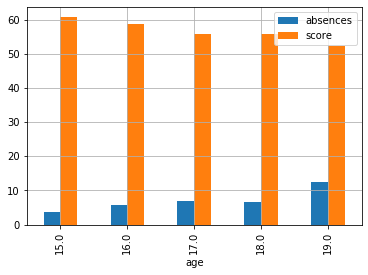

In [21]:
stud_age = stud[stud['age'] < 20]
stud_age.pivot_table(values=['score', 'absences'], index='age',
                     aggfunc='mean').plot(kind='bar', grid=True)

### На графике видно, что с возрастом средняя оценка за экзамен падает, а количество пропусков занятий, наоборот, растет.

## 6. Address

In [22]:
stud.address = normalizeAddress()

In [23]:
stud['address'].value_counts(dropna=False, normalize=False)

urban       283
suburban     73
Name: address, dtype: int64

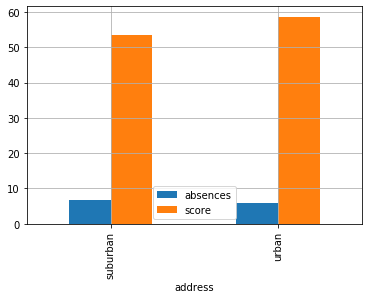

In [24]:
stud.pivot_table(values=['score', 'absences'], index='address',
                 aggfunc='mean').plot(kind='bar', grid=True)

### На графике видно, что дети, проживающие в городе имеют в среднем лучше результаты за экзамен и меньше пропущенных занятий, чем дети, проживающие за городом. 

<h2>6. Famsize<h2>

In [25]:
stud.famsize = normalizeFamSize()
stud['famsize'].value_counts(dropna=False, normalize=False)

more 3             257
less or equal 3     99
Name: famsize, dtype: int64

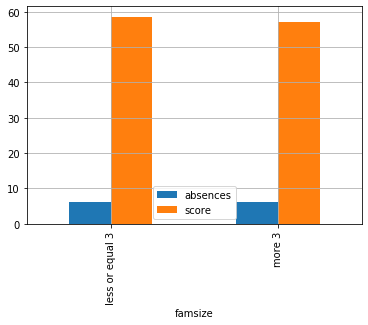

In [26]:
stud.pivot_table(values=['score', 'absences'], index='famsize',
                 aggfunc='mean').plot(kind='bar', grid=True)

### Считаю, что размер семьи не влияет на посещаемость и результаты экзамена. 

## 7. Pstatus

In [27]:
stud.Pstatus = normalizeParentStatus()
stud['Pstatus'].value_counts(dropna=False, normalize=False)

together    323
apart        33
Name: Pstatus, dtype: int64

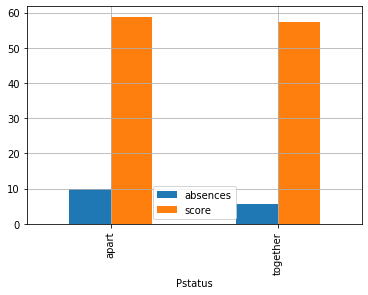

In [28]:
stud.pivot_table(values=['score', 'absences'], index='Pstatus',
                 aggfunc='mean').plot(kind='bar', grid=True)

### Основываясь на графике выше, можно сделать вывод, что проживают ли родители вместе или нет не влияет на результат на экзамене. Но дети, у которых родители живут раздельно, чаще прогуливают занятия.

## 8. Medu

In [29]:
stud.Medu = normalizeEducation(stud.Medu)
stud['Medu'].value_counts(dropna=False, normalize=False)

higher          127
5-9 gr.          88
secondary        88
1-4 gr.          50
no education      3
Name: Medu, dtype: int64

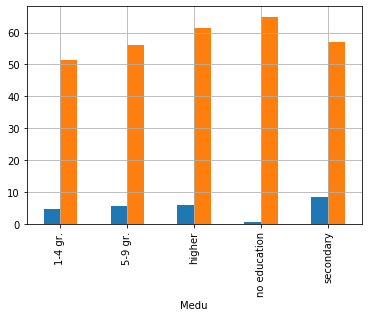

In [30]:
stud.pivot_table(values=['score', 'absences'], index='Medu',
                 aggfunc='mean').plot.bar(grid=True, legend=False)

### Основываясь на графике выше, можно сделать вывод, что дети, у которых матери без образования, получают оценки выше. Я считаю, что это связано с небольшим количеством представленных данных (только в 3 записях). Если исключить из внимания случаи, где матери не имеют образования, то можно заметить, что образование матери оказывает влияние на результаты экзамена - у матерей с высшим образованием дети получают выше балл за экзамен.

## 9. Fedu

In [31]:
stud.Fedu = normalizeEducation(stud.Fedu)
stud['Fedu'].value_counts(dropna=False, normalize=False)

5-9 gr.         115
secondary        90
higher           80
1-4 gr.          68
no education      2
40.0              1
Name: Fedu, dtype: int64

### Т.к. значения должны быть в диапазоне от 0 до 4, то можно сделать вывод, что есть некорректные данные (значение 40).  


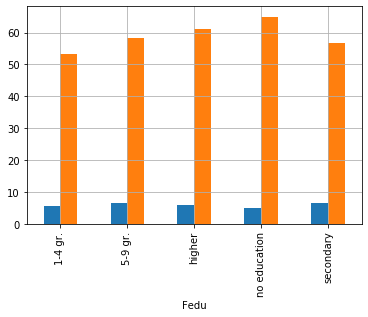

In [32]:
stud = stud[stud['Fedu'] != '40.0']
stud.pivot_table(values=['score', 'absences'], index='Fedu',
                 aggfunc='mean').plot.bar(grid=True, legend=False)

### Основываясь на графике выше, можно сделать вывод, что дети, у которых отцы без образования, получают оценки выше. Я считаю, что это связано с небольшим количеством представленных данных (только в 2 записях). Если исключить из внимания случаи, где отцы не имеют образования, то можно заметить, что образование отца оказывает влияние на результаты экзамена - у отца с высшим образованием дети получают выше балл за экзамен.


## 10. Mjob 

In [33]:
stud['Mjob'].value_counts(dropna=False, normalize=False)

other       138
services     87
teacher      51
at_home      49
health       30
Name: Mjob, dtype: int64

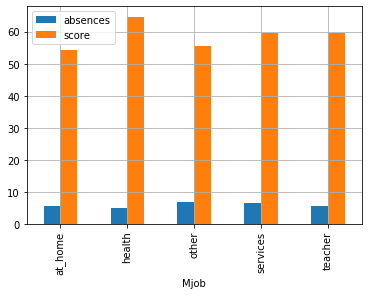

In [34]:
stud.pivot_table(values=['score', 'absences'], index='Mjob',
                 aggfunc='mean').plot(kind='bar', grid=True, legend=True)

### Самый высокий бал наблюдается у детей, чьи матери работают в сфере медицины.

## 11. Fjob

In [35]:
stud['Fjob'].value_counts(dropna=False, normalize=False)

other       210
services     91
teacher      25
health       15
at_home      14
Name: Fjob, dtype: int64

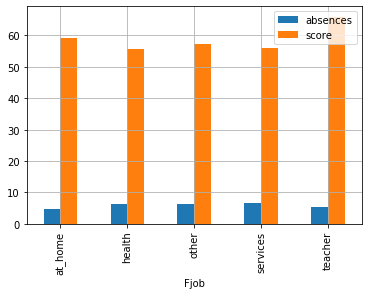

In [36]:
stud.pivot_table(values=['score', 'absences'], index='Fjob',
                 aggfunc='mean').plot(kind='bar', grid=True, legend=True)

### Самый высокий средний бал наблюдается у детей, чьи отцы работают учителем.

## 12. reason 

In [37]:
stud['reason'].value_counts(dropna=False, normalize=False)

course        135
reputation     96
home           92
other          32
Name: reason, dtype: int64

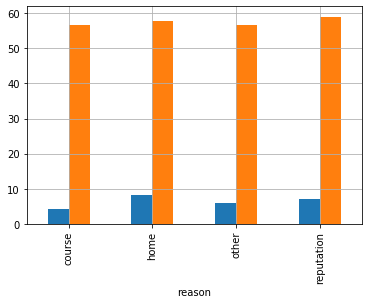

In [38]:
stud.pivot_table(values=['score', 'absences'], index='reason',
                 aggfunc='mean').plot(kind='bar', grid=True, legend=False)

### Считаю, что эти данные не оказывают сильное влияние на результат экзамена.

## 13. guardian 

In [39]:
stud['guardian'].value_counts(dropna=False, normalize=False)

mother    254
father     77
other      24
Name: guardian, dtype: int64

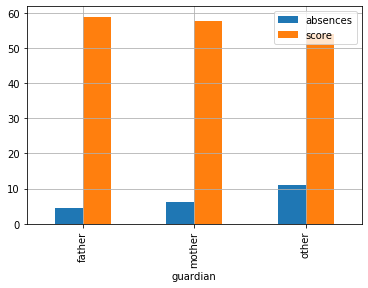

In [40]:
stud.pivot_table(values=['score', 'absences'], index='guardian',
                 aggfunc='mean').plot(kind='bar', grid=True, legend=True)

### Самые лучшие показатели учебы (посещаемость и оценки за экзамен) у детей, у которых опекуном является отец или мать. 

## 14. traveltime 

In [41]:
stud.traveltime = normalizeTraveltime()
stud['traveltime'].value_counts(dropna=False, normalize=False)

<15 min      243
15-30 min     88
30-60 min     17
>60 min        7
Name: traveltime, dtype: int64

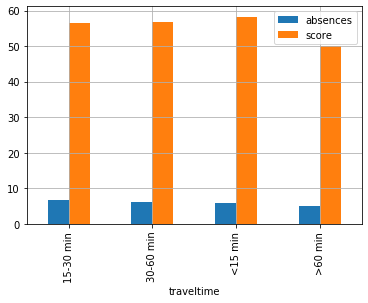

In [42]:
stud.pivot_table(values=['score', 'absences'], index='traveltime',
                 aggfunc='mean').plot(kind='bar', grid=True, legend=True)

### На графике видно, что только при значении более 60 минут оценки за экзамен значительно ниже.

### 15. studytime 

In [43]:
stud.studytime = normalizeStudytime()
stud['studytime'].value_counts(dropna=False, normalize=False)

2-5 h     183
<2 h       90
5-10 h     58
>10 h      24
Name: studytime, dtype: int64

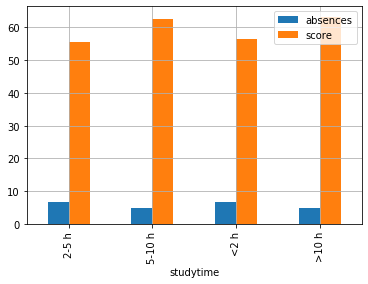

In [44]:
stud.pivot_table(values=['score', 'absences'], index='studytime',
                 aggfunc='mean').plot(kind='bar', grid=True, legend=True)

### На графике видно, что высокие оценки за экзамен в среднем лучше при занятиях помимо школы более 5 часов  в неделю и выше.

## 16.failures

In [45]:
stud['failures'].value_counts(dropna=False, normalize=False)

0.0    294
1.0     39
3.0     11
2.0     11
Name: failures, dtype: int64

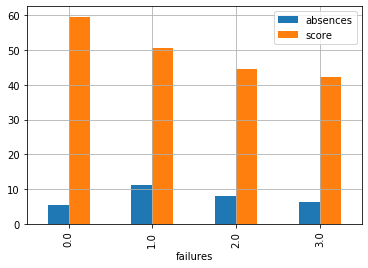

In [46]:
stud.pivot_table(values=['score', 'absences'], index='failures',
                 aggfunc='mean').plot(kind='bar', grid=True, legend=True)

### На графике видно, что чем больше внеучебных неудач, тем ниже результаты за экзамен.

## 17. schoolsup 

In [47]:
stud.schoolsup = replaceNullToNaN(stud.schoolsup)
stud['schoolsup'].value_counts(dropna=False, normalize=True)

no     0.861972
yes    0.138028
Name: schoolsup, dtype: float64

### У почти 86% школьников нет дополнительной образовательной поддержки. 

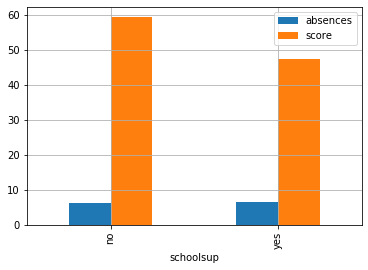

In [48]:
stud.pivot_table(values=['score', 'absences'], index='schoolsup',
                 aggfunc='mean').plot(kind='bar', grid=True, legend=True)

### При отсутствии образовательной поддержки результаты за экзамен лучше. На посещаемость этот признак не сказывается.

## 18. famsup 

In [49]:
stud['famsup'].value_counts(dropna=False, normalize=False)

yes    233
no     122
Name: famsup, dtype: int64

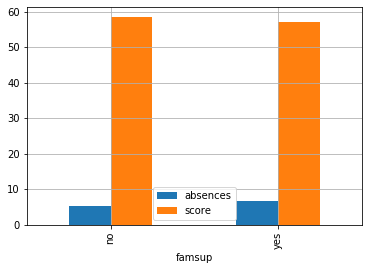

In [50]:
stud.pivot_table(values=['score', 'absences'], index='famsup',
                 aggfunc='mean').plot(kind='bar', grid=True, legend=True)

### Насмотря на то, что при отсутствии поддержки балл за экзамен выше, большого влияния не наблюдается.

## 19. paid

In [51]:
stud['paid'].value_counts(dropna=False, normalize=False)

no     208
yes    147
Name: paid, dtype: int64

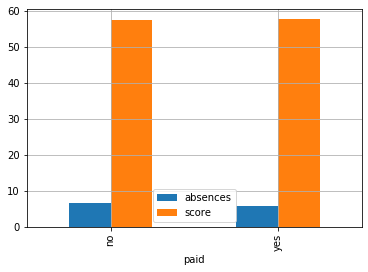

In [52]:
stud.pivot_table(values=['score', 'absences'], index='paid',
                 aggfunc='mean').plot(kind='bar', grid=True, legend=True)

### Считаю, что наличие платных занятий не оказывают сильное влияние на результат экзамена.

## 20. activities 

In [53]:
stud['activities'].value_counts(dropna=False, normalize=False)

yes    186
no     169
Name: activities, dtype: int64

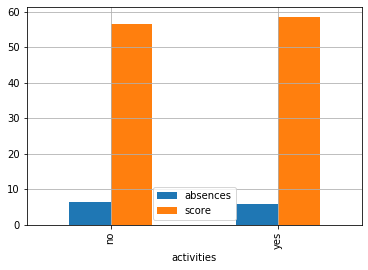

In [54]:
stud.pivot_table(values=['score', 'absences'], index='activities',
                 aggfunc='mean').plot(kind='bar', grid=True, legend=True)

### На графике видно, что при дополнительных внеучебных занятиях средний балл за экзамен немного выше.

## 21. nursery

In [55]:
stud['nursery'].value_counts(dropna=False, normalize=True)

yes    0.802817
no     0.197183
Name: nursery, dtype: float64

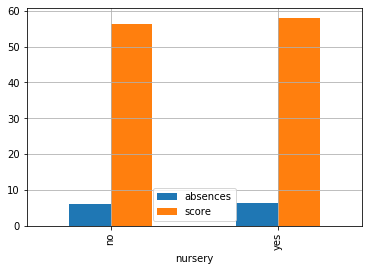

In [56]:
stud.pivot_table(values=['score', 'absences'], index='nursery',
                 aggfunc='mean').plot(kind='bar', grid=True, legend=True)

### Около 80% детей посещали детский сад, но это не оказало сильного влияния на результаты экзамена.

## 22. higher 

In [57]:
stud['higher'].value_counts(dropna=False, normalize=False)

yes    342
no      13
Name: higher, dtype: int64

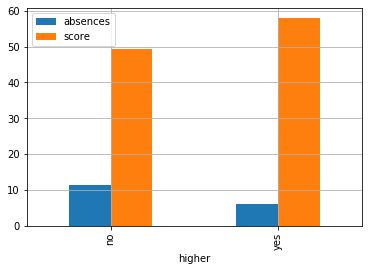

In [58]:
stud.pivot_table(values=['score', 'absences'], index='higher',
                 aggfunc='mean').plot(kind='bar', grid=True, legend=True)

### По графику видно, что желание иметь высшее образование сказывается на результаты экзамена - выше средний балл выше, пропусков занятий - ниже.

## 23. internet 

In [59]:
stud['internet'].value_counts(dropna=False, normalize=False)

yes    306
no      49
Name: internet, dtype: int64

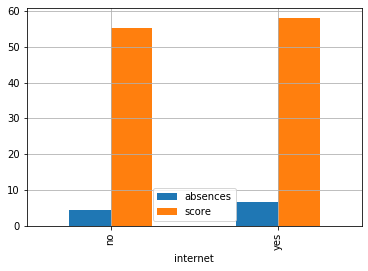

In [60]:
stud.pivot_table(values=['score', 'absences'], index='internet',
                 aggfunc='mean').plot(kind='bar', grid=True, legend=True)

### Наличие интернета оказывает незначительное влияние на результаты экзамена.

## 24. romantic 

In [61]:
stud['romantic'].value_counts(dropna=False, normalize=False)

no     250
yes    105
Name: romantic, dtype: int64

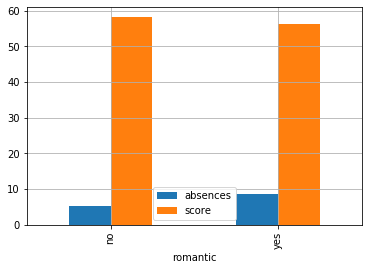

In [62]:
stud.pivot_table(values=['score', 'absences'], index='romantic',
                 aggfunc='mean').plot(kind='bar', grid=True, legend=True)

### Наличие романтических отношений небольшое негативное влияние на обучение детей.

## 25. famrel 

In [63]:
stud['famrel'].value_counts(dropna=False, normalize=False)

 4.0    191
 5.0     88
 3.0     56
 2.0     13
 1.0      6
-1.0      1
Name: famrel, dtype: int64

### Значения должны быть в диапозоне от 1 до 5. Значение -1 является некорректным, поэтому его можно удалить.

In [64]:
stud = stud[stud['famrel'] > 0]

In [65]:
stud['famrel'].value_counts(dropna=False, normalize=False)

4.0    191
5.0     88
3.0     56
2.0     13
1.0      6
Name: famrel, dtype: int64

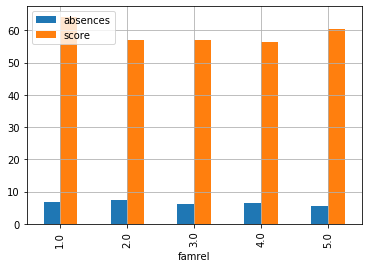

In [66]:
stud.pivot_table(values=['score', 'absences'], index='famrel',
                 aggfunc='mean').plot(kind='bar', grid=True, legend=True)

### Влияния семейных отношений на успеваемость не наблюдается.

## 26. freetime 

In [67]:
stud['freetime'].value_counts(dropna=False, normalize=False)

3.0    142
4.0    104
2.0     57
5.0     35
1.0     16
Name: freetime, dtype: int64

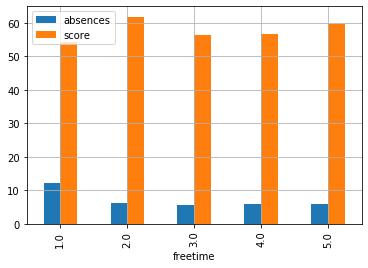

In [68]:
stud.pivot_table(values=['score', 'absences'], index='freetime',
                 aggfunc='mean').plot(kind='bar', grid=True, legend=True)

### Свободное время после школы не влияет на оценки экзамена.

## 27.goout 

In [69]:
stud['goout'].value_counts(dropna=False, normalize=False)

3.0    126
2.0     90
4.0     76
5.0     44
1.0     18
Name: goout, dtype: int64

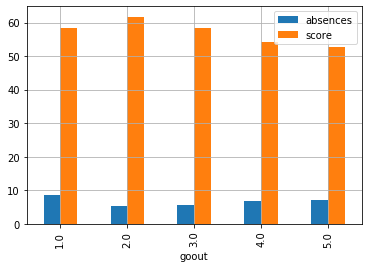

In [70]:
stud.pivot_table(values=['score', 'absences'], index='goout',
                 aggfunc='mean').plot(kind='bar', grid=True, legend=True)

### Результат показывает, что частое общение с друзьями плохо влияет на успеваемость, так же как и очень редкое общение.

## 28. health 

In [71]:
stud['health'].value_counts(dropna=False, normalize=False)

5.0    137
3.0     81
4.0     54
1.0     45
2.0     37
Name: health, dtype: int64

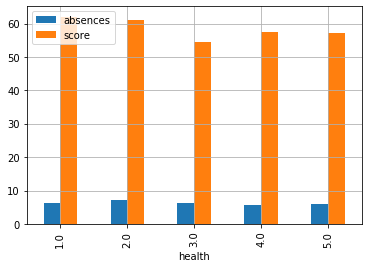

In [72]:
stud.pivot_table(values=['score', 'absences'], index='health',
                 aggfunc='mean').plot(kind='bar', grid=True, legend=True)

### Здоровье не оказывает сильного влияния на успеваемость.

### 29. studytime, granular

In [73]:
stud['studytime, granular'].value_counts(dropna=False, normalize=False)

-6.0     183
-3.0      89
-9.0      58
-12.0     24
Name: studytime, granular, dtype: int64

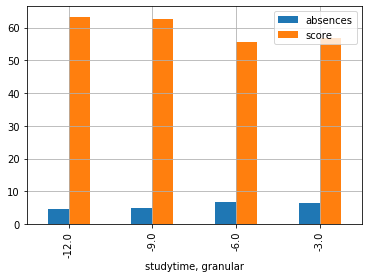

In [74]:
stud.pivot_table(values=['score', 'absences'], index='studytime, granular',
                 aggfunc='mean').plot(kind='bar', grid=True, legend=True)

### Данный столбец не описан в задании. Но если посмотреть внимательнее на данные, то можно заметить, что данный столбец = studytime * (-3). Поэтому его можно удалить как дублирующий.

In [75]:
stud.drop(['studytime, granular'], inplace=True, axis=1)

# Корреляционный анализ

In [76]:
stud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354 entries, 0 to 394
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      354 non-null    object 
 1   sex         354 non-null    object 
 2   age         354 non-null    float32
 3   address     354 non-null    object 
 4   famsize     354 non-null    object 
 5   Pstatus     354 non-null    object 
 6   Medu        354 non-null    object 
 7   Fedu        354 non-null    object 
 8   Mjob        354 non-null    object 
 9   Fjob        354 non-null    object 
 10  reason      354 non-null    object 
 11  guardian    354 non-null    object 
 12  traveltime  354 non-null    object 
 13  studytime   354 non-null    object 
 14  failures    354 non-null    object 
 15  schoolsup   354 non-null    object 
 16  famsup      354 non-null    object 
 17  paid        354 non-null    object 
 18  activities  354 non-null    object 
 19  nursery     354 non-null    o

In [77]:
stud.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout',
       'health', 'absences', 'score'],
      dtype='object')

In [78]:
new_stud = stud.copy(deep=True)
new_stud.drop(['school', 'sex', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
               'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
               'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
               'higher', 'internet', 'romantic'], inplace=True, axis=1)

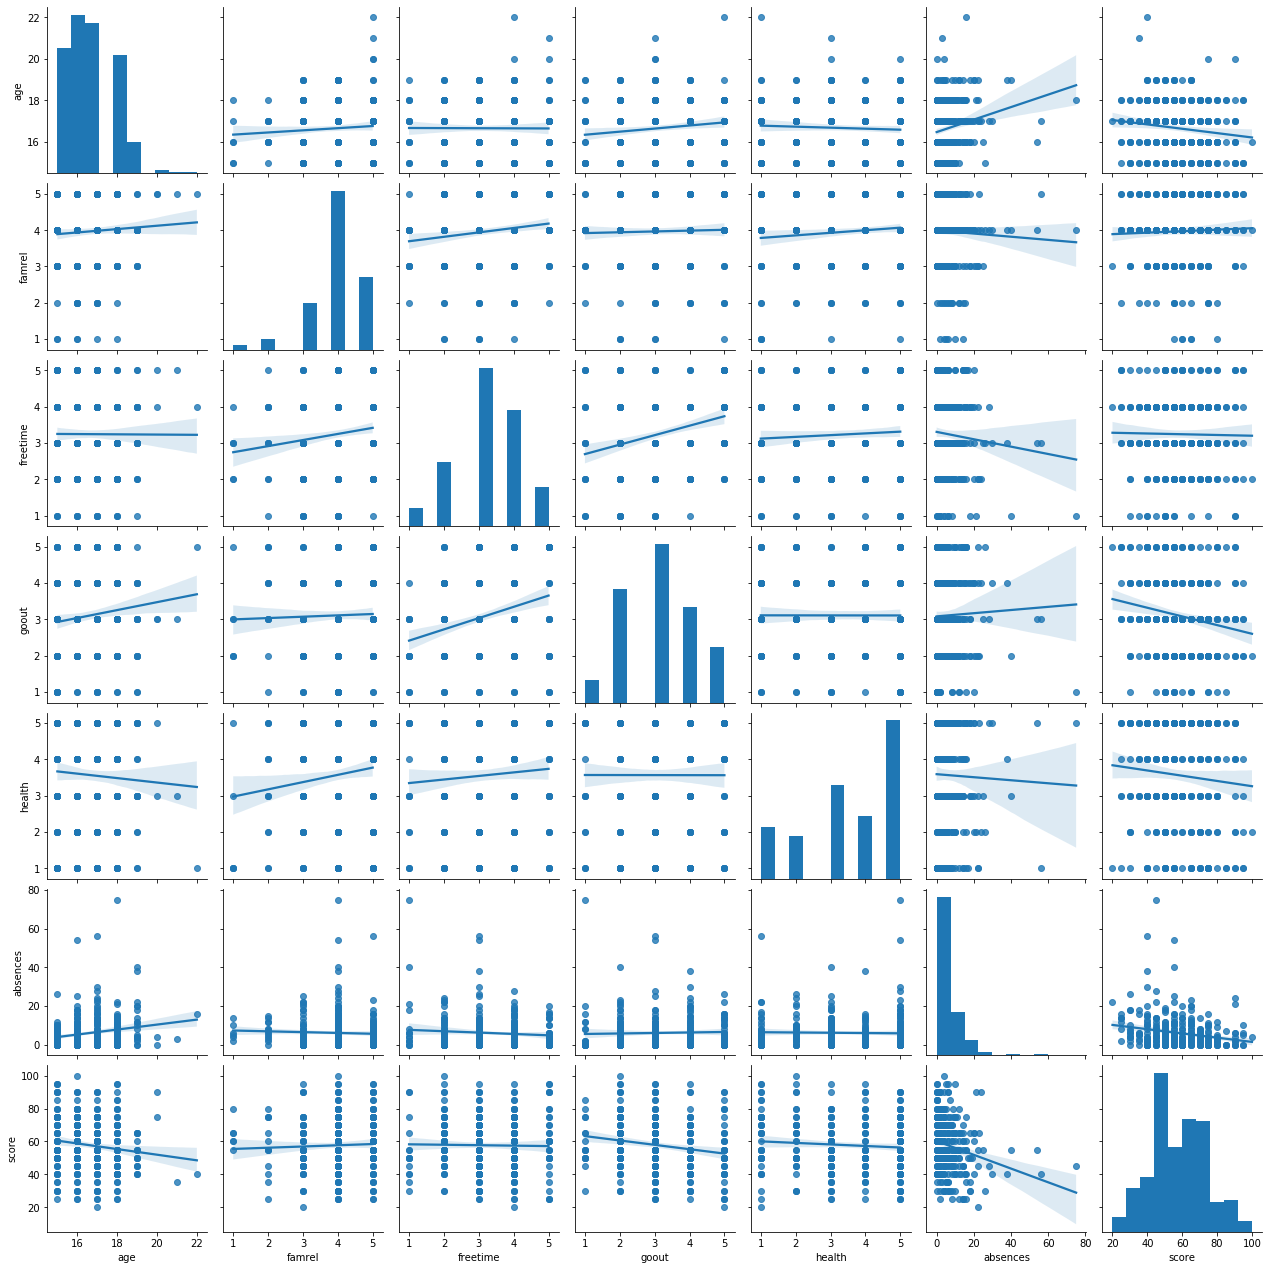

In [79]:
sns.pairplot(new_stud, kind='reg')

In [80]:
new_stud.corr()

,age,famrel,freetime,goout,health,absences,score
age,1.000000,0.069295,-0.004432,0.127334,-0.054606,0.196759,-0.133930
famrel,0.069295,1.000000,0.142808,0.029038,0.118762,-0.042711,0.039083
freetime,-0.004432,0.142808,1.000000,0.284366,0.068455,-0.084575,-0.016639
goout,0.127334,0.029038,0.284366,1.000000,-0.001072,0.033456,-0.178187
health,-0.054606,0.118762,0.068455,-0.001072,1.000000,-0.024315,-0.082049
absences,0.196759,-0.042711,-0.084575,0.033456,-0.024315,1.000000,-0.214053
score,-0.133930,0.039083,-0.016639,-0.178187,-0.082049,-0.214053,1.000000


### Отрицательная корреляция параметров absences и score может говорить о том, что чем меньше ученик прогуливает занятия, тем лучше результат на экзамене. Также отрицательная корреляция параметров score и goout (проведение времени с друзьями) показывает, что чем меньше ученик проводит времени с друзьями, тем выше балл на экзамене. Также наблюдается отрицательная корреляция параметров age и score, которая показывает, что с возрастом балл за экзамен уменьшается.

# Анализ номинативных переменных

In [81]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.boxplot(x=column, y='score',
                data=stud.loc[stud.loc[:, column].isin(
                    stud.loc[:, column].value_counts().index[:10])],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

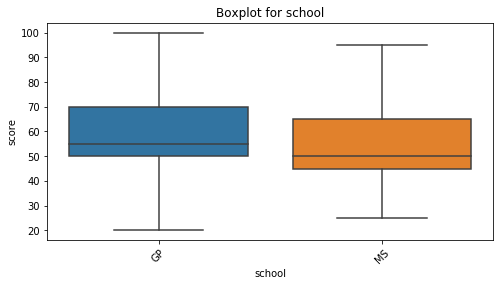

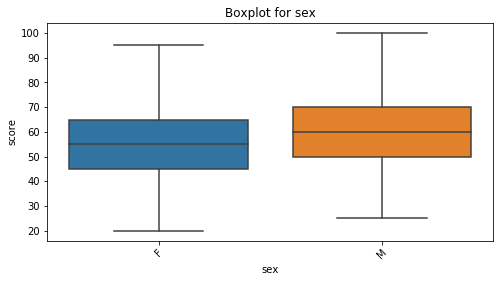

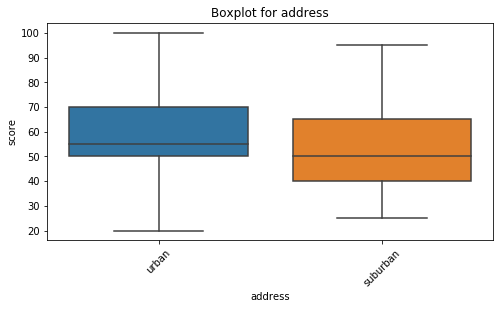

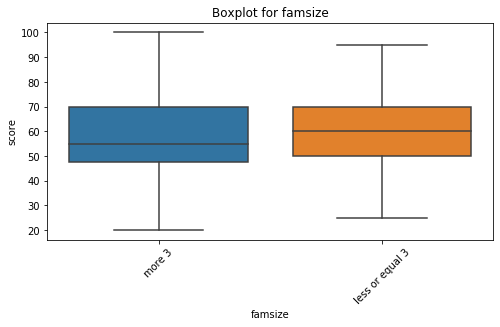

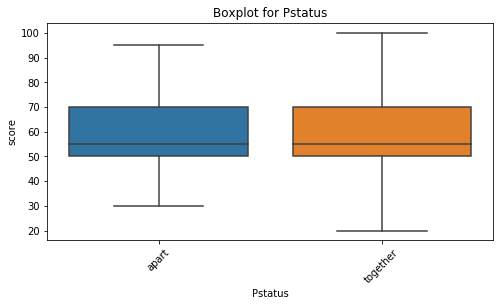

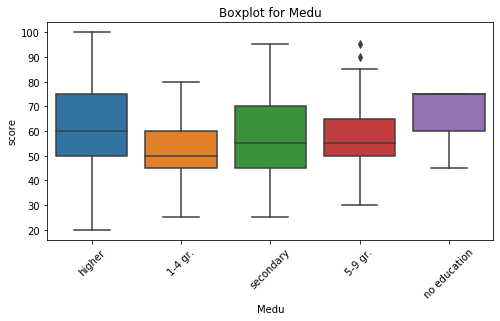

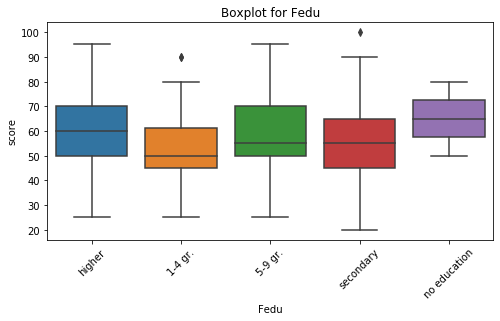

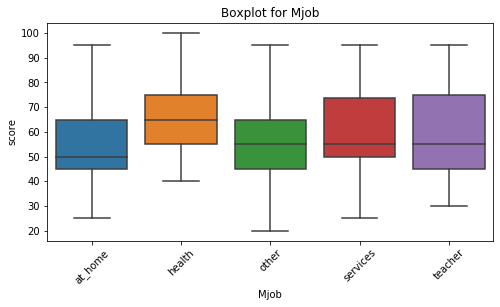

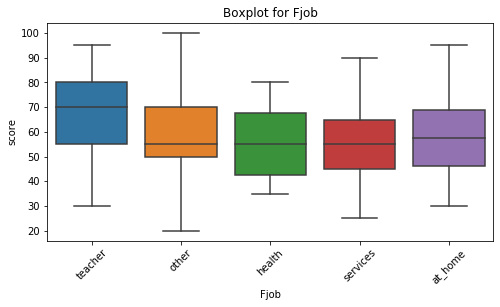

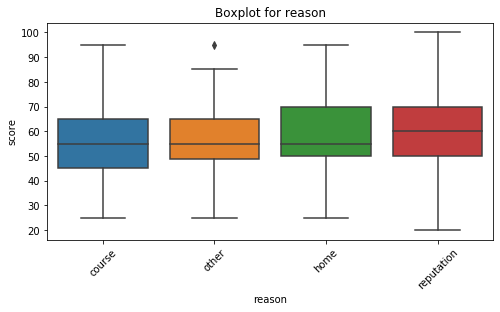

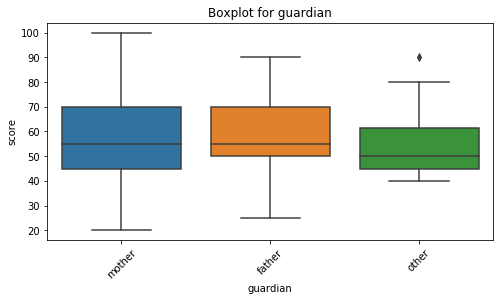

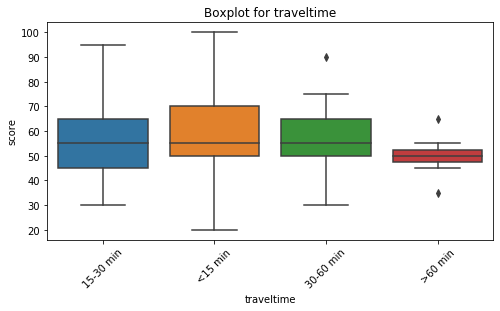

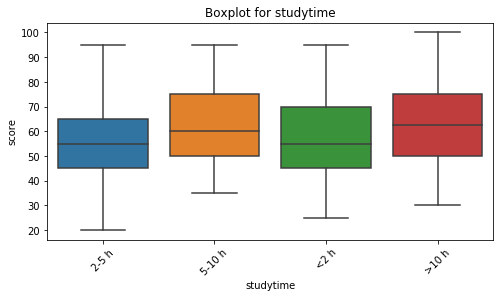

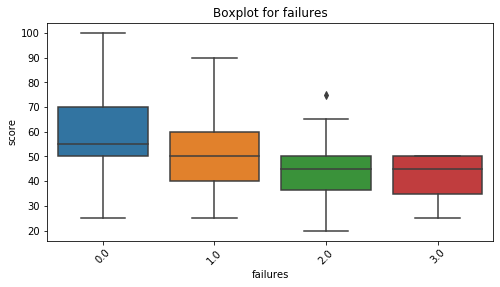

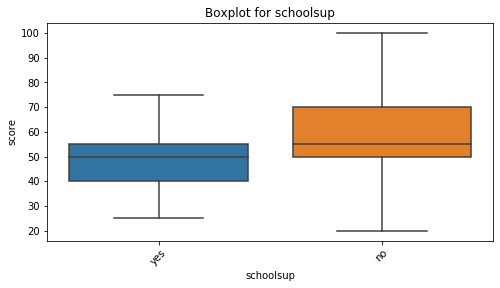

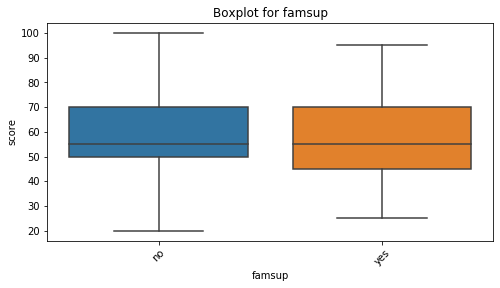

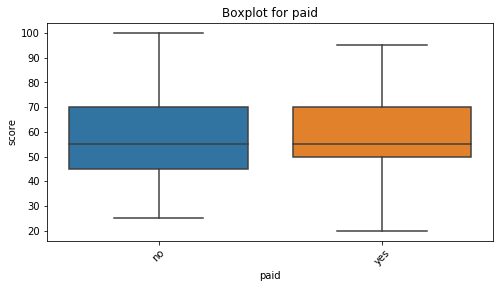

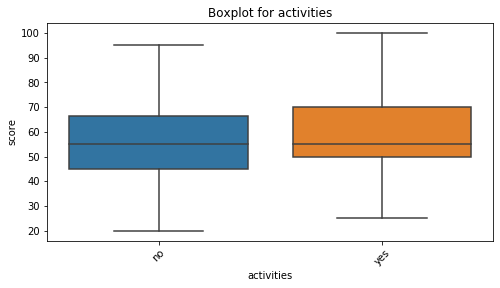

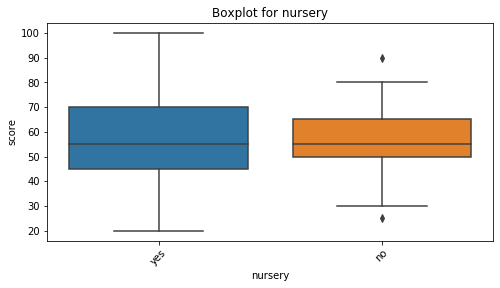

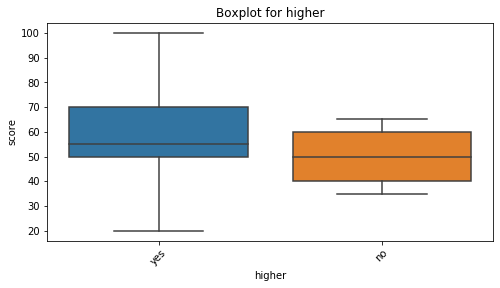

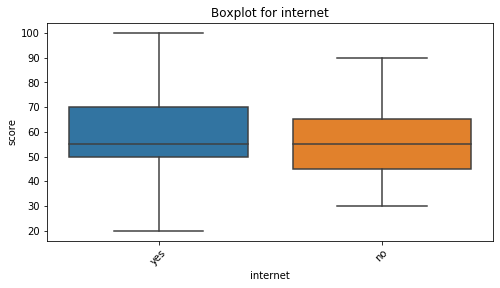

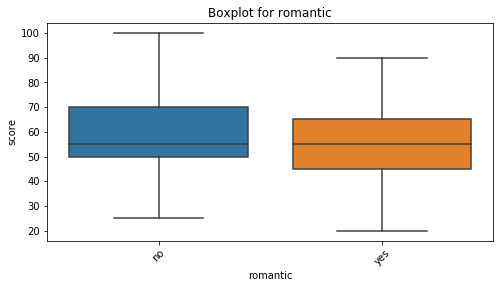

In [82]:
for col in ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
            'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
            'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
            'higher', 'internet', 'romantic']:
    get_boxplot(col)

### Судя по графикам наибольшее влияние оказывают параметры: school, sex, address, Medu, Fedu, Mjob, Fjob, guardian, traveltime, failures, schoolsup, higher.

## Тест Стьюдента

In [83]:
def get_stat_dif(column):
    cols = stud.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(stud.loc[stud.loc[:, column] == comb[0], 'score'],
                     stud.loc[stud.loc[:, column] == comb[1], 'score']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [84]:
for col in ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
            'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
            'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
            'higher', 'internet', 'romantic']:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки Medu
Найдены статистически значимые различия для колонки Fedu
Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки studytime
Найдены статистически значимые различия для колонки failures
Найдены статистически значимые различия для колонки schoolsup


## На основе полученных данных оставим необходимые переменные в датасете  для построения модели.

In [85]:
stud_for_model = stud.loc[:, ['sex', 'age', 'address', 'Medu', 'Fedu',
                              'Mjob', 'studytime', 'failures', 'schoolsup',
                              'higher', 'goout', 'absences', 'score']]
stud_for_model.head()

,sex,age,address,Medu,Fedu,Mjob,studytime,failures,schoolsup,higher,goout,absences,score
0,F,18.0,urban,higher,higher,at_home,2-5 h,0,yes,yes,4.0,6.0,30.0
1,F,17.0,urban,1-4 gr.,1-4 gr.,at_home,2-5 h,0,no,yes,3.0,4.0,30.0
2,F,15.0,urban,1-4 gr.,1-4 gr.,at_home,2-5 h,3,yes,yes,2.0,10.0,50.0
3,F,15.0,urban,higher,5-9 gr.,health,5-10 h,0,no,yes,2.0,2.0,75.0
4,F,16.0,urban,secondary,secondary,other,2-5 h,0,no,yes,2.0,4.0,50.0


# Выводы

## 1. В данных было много пустых значений. Не имеют пропущенных значений только столбцы school, age, sex.

## 2. Выбросы найдены в столбцах с образование отца, семейные отношения, количество пропущенных занятий и баллы по госэкзамену по математике. Это позволяет сделать вывод, что данные не достаточно чистые.

## 3. Отрицательная корреляция параметров absences и score может говорить о том, что чем меньше ученик прогуливает занятия, тем лучше результат на экзамене. Также отрицательная корреляция параметров score и goout (проведение времени с друзьями) показывает, что чем меньше ученик проводит времени с друзьями, тем выше балл на экзамене. Также наблюдается отрицательная корреляция параметров age и score, которая показывает, что с возрастом балл за экзамен уменьшается.

## 4. Самые важные параметры, которые предлагается использовать в дальнейшем для построения модели, это sex, age, address, Medu, Fedu, Mjob, studytime, failures, schoolsup, higher, goout, absences, score.